In [1]:
import pandas as pd
import torch
import math
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from math import exp
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os

import networkx as nx
import matplotlib as mpl

from biological_fuzzy_logic_networks.DREAM.DREAMBioFuzzNet import DREAMBioFuzzNet, DREAMBioMixNet
from biological_fuzzy_logic_networks.DREAM_analysis.utils import create_bfz
from biological_fuzzy_logic_networks.manuscripts_functions.colors import cmap_24, default_hex

/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fontsize = 12

In [3]:
sns.set_theme(font="Arial", style="ticks", rc={"font.size": fontsize,"axes.titlesize":fontsize,"axes.labelsize":fontsize, 
                                               "xtick.labelsize": fontsize, "ytick.labelsize": fontsize, "legend.fontsize": fontsize})
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = fontsize

In [4]:
ZERO_THRESHOLD = 0.05
exp_dir = "/dccstor/ipc1/CAR/BFN/Model/Gates/"
n_repeats = 5
n_gates_max = 22
pkn = "/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN.sif"

# or load config: /u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/Synthetic_experiments/base_gate_config.json

In [5]:
def get_results(true_network, optimized_network, num_gates, fold, threshold = ZERO_THRESHOLD):
    """
    Parameters:
        true_networks_list: list containing the true network structure for all 10 folds
        optimized_networks_list: list containing the optimized biomixnet structure for all 10 folds, n the same order as true_networks_list
        num_gates: int, number of gates that were optimized
        treshold: zero threshold for comparing to ideal gate vaule (0 or 1)

    """
    
    with torch.no_grad():
        res = []
        for mixed in optimized_network.mixed_gates:
            solution_dic = {}
            solution_dic["Num gates"] = num_gates
            solution_dic["Fold"] = fold
            true_type = true_network.nodes()[mixed]["node_type"]
            solution_dic["Gate"] = mixed
            solution_dic["True type"] = true_type
            param = torch.sigmoid(optimized_network.nodes()[mixed]["gate"].AND_param)
            if (1-param) <= threshold:
                solution_dic["Predicted type"] = "logic_gate_AND"
            elif (param) <= threshold:
                solution_dic["Predicted type"] = "logic_gate_OR"
            else:
                solution_dic["Predicted type"] = "Unknown"
                print(f"Unable to decide gate at threshold {threshold}, AND_param has value {param}")
            solution_dic["Gate AND param"] = float(param.data)
            solution_dic["Correctly predicted"] = solution_dic["Predicted type"] == solution_dic["True type"]
            res.append(solution_dic)
            
        if num_gates==0:
            solution_dic = {}
            solution_dic["Num gates"] = num_gates
            solution_dic["Fold"] = fold
            solution_dic["Gate"] = "None"
            solution_dic["True type"] = np.nan
            solution_dic["Predicted type"] = np.nan
            solution_dic["Gate AND param"] = np.nan
            solution_dic["Correctly predicted"] = True
            res.append(solution_dic)

        solution = pd.DataFrame(res)
        
    return solution 


In [6]:
def compute_test_set_RMSE(test_ground_truth, test_predicted):
    
    rmse = {}
    for node in test_ground_truth.columns:
        rmse[node] = math.sqrt(
            sum((test_predicted[node] - test_ground_truth[node]) ** 2)
            / len(test_predicted[node])
        )
    return rmse

In [7]:
def create_models(ckpt, pkn, modelclass):
    m = create_bfz(pkn, modelclass)
    m.load_from_checkpoint(ckpt["model_state_dict"], ckpt["model_gate_dict"])
    return m

In [8]:
def get_all_results(exp_dir, num_gates_max, num_folds, pkn_path,
                   true_network_suffix, trained_network_suffix, changed_gates_suffix,
                   true_data_suffix, test_data_suffix):
    """
    data_folder: path to directory with data
    CV_folder: name template of the folder (inside data_folder) containing the generated data for the folds. it is then assumed to be labeled as CV_folder_{i} for fold i
    gate_folder: name template of the folder  (inside data_folder) containing the result data for the different number of mixed gates. it is then assumed to be labeled as gate_folder_{n} for number of mixed gates n
    num_gates_max: maximum number of introduced mixed gates so that all solutions from 1 mixed gate to num_ègates_max mixed gates are enumerated
    """
    all_solutions = []
    RMSEs = []
    num_gates_max = num_gates_max+1

    ckpts = [torch.load(f"{exp_dir}{j}_gates_{i}_repeat_{true_network_suffix}") for i in range(num_folds) for j in range(0, num_gates_max)]
    true_networks = list(map(lambda x: create_models(x, pkn, "DREAMBioFuzzNet"), ckpts))
    
    ckpts = [torch.load(f"{exp_dir}{j}_gates_{i}_repeat_{trained_network_suffix}") for i in range(num_folds) for j in range(0, num_gates_max)]
    optimized_networks = list(map(lambda x: create_models(x, pkn, "DREAMBioMixNet"), ckpts))
    
    true_output = [pd.read_csv(f"{exp_dir}{j}_gates_{i}_repeat_{true_data_suffix}") for i in range(num_folds) for j in range(0, num_gates_max)]
    test_output = [pd.read_csv(f"{exp_dir}{j}_gates_{i}_repeat_{test_data_suffix}") for i in range(num_folds) for j in range(0, num_gates_max)]
        
    num_gates = [j for i in range(num_folds) for j in range(0, num_gates_max)]
    folds = [i for i in range(num_folds) for j in range(num_gates_max)]
    
    all_networks = list(zip(true_networks, optimized_networks, num_gates, folds))
    all_res =  [get_results(*n) for n in all_networks]
    all_res = pd.concat(all_res, ignore_index=True)

    rmse = pd.DataFrame([compute_test_set_RMSE(*data) for data in list(zip(true_output, test_output))])
    rmse["Fold"] = folds
    rmse["Num gates"] = num_gates
    
    return all_res, rmse

In [10]:
results_df, RMSEs = get_all_results(exp_dir, n_gates_max, n_repeats, pkn, 
                                    true_network_suffix="model_for_simulation.pt",
                                   trained_network_suffix="model_for_prediction.pt",
                                   changed_gates_suffix="changed_gates.p",
                                   true_data_suffix="test_true.csv",
                                   test_data_suffix="test_output.csv")

Unable to decide gate at threshold 0.05, AND_param has value 0.5302899100283953


In [11]:
results_df

,Num gates,Fold,Gate,True type,Predicted type,Gate AND param,Correctly predicted
0,0,0,None,NaN,NaN,NaN,True
1,1,0,_and_6,logic_gate_OR,logic_gate_OR,0.005879,True
2,2,0,_and_5,logic_gate_AND,logic_gate_AND,0.994124,True
3,2,0,_and_6,logic_gate_AND,logic_gate_AND,0.994127,True
4,3,0,_and_5,logic_gate_OR,logic_gate_AND,0.994120,False
...,...,...,...,...,...,...,...
1265,22,4,or7,logic_gate_AND,logic_gate_AND,0.994105,True
1266,22,4,or8,logic_gate_AND,logic_gate_AND,0.994026,True
1267,22,4,or9,logic_gate_OR,logic_gate_AND,0.993876,False
1268,22,4,or10,logic_gate_AND,logic_gate_AND,0.994216,True


In [12]:
print("CORRECT GATE PREDICTIONS SUMMARY")
print(f"Correctly predicted gates overall: {results_df['Correctly predicted'].sum()/len(results_df)*100} %")
AND_gates = results_df[results_df["True type"] == "logic_gate_AND"]
print(f"Correctly predicted AND gates overall: {AND_gates['Correctly predicted'].sum()/len(AND_gates)*100} %")
OR_gates = results_df[results_df["True type"] == "logic_gate_OR"]
print(f"Correctly predicted OR gates overall: {OR_gates['Correctly predicted'].sum()/len(OR_gates)*100} %")

CORRECT GATE PREDICTIONS SUMMARY
Correctly predicted gates overall: 70.07874015748031 %
Correctly predicted AND gates overall: 70.06369426751591 %
Correctly predicted OR gates overall: 69.85871271585557 %


In [13]:
print("CORRECT PREDICTIONS PER NUMBER OF MIXED GATES IN NETWORK")

for num_gates in range(n_gates_max+1):
    print(f"\nNUMBER OF MIXED GATES: {num_gates}")
    fold_df = results_df[results_df["Num gates"] == num_gates]
    print(f"Correctly predicted gates overall: {fold_df['Correctly predicted'].sum()/len(fold_df)*100} %")
    AND_gates = fold_df[fold_df["True type"] == "logic_gate_AND"]
    print(f"Correctly predicted AND gates overall: {AND_gates['Correctly predicted'].sum()/len(AND_gates)*100} %")
    OR_gates = fold_df[fold_df["True type"] == "logic_gate_OR"]
    print(f"Correctly predicted OR gates overall: {OR_gates['Correctly predicted'].sum()/len(OR_gates)*100} %")


CORRECT PREDICTIONS PER NUMBER OF MIXED GATES IN NETWORK

NUMBER OF MIXED GATES: 0
Correctly predicted gates overall: 100.0 %
Correctly predicted AND gates overall: nan %
Correctly predicted OR gates overall: nan %

NUMBER OF MIXED GATES: 1
Correctly predicted gates overall: 60.0 %
Correctly predicted AND gates overall: 0.0 %
Correctly predicted OR gates overall: 75.0 %

NUMBER OF MIXED GATES: 2
Correctly predicted gates overall: 100.0 %
Correctly predicted AND gates overall: 100.0 %
Correctly predicted OR gates overall: 100.0 %

NUMBER OF MIXED GATES: 3
Correctly predicted gates overall: 80.0 %
Correctly predicted AND gates overall: 80.0 %
Correctly predicted OR gates overall: 80.0 %

NUMBER OF MIXED GATES: 4
Correctly predicted gates overall: 90.0 %
Correctly predicted AND gates overall: 100.0 %
Correctly predicted OR gates overall: 81.81818181818183 %

NUMBER OF MIXED GATES: 5
Correctly predicted gates overall: 80.0 %
Correctly predicted AND gates overall: 71.42857142857143 %
Correc

/tmp/ipykernel_3440671/980208330.py:8: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Correctly predicted AND gates overall: {AND_gates['Correctly predicted'].sum()/len(AND_gates)*100} %")
/tmp/ipykernel_3440671/980208330.py:10: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Correctly predicted OR gates overall: {OR_gates['Correctly predicted'].sum()/len(OR_gates)*100} %")


In [14]:
print("RMSEs")
num_gates_max = 22
for num_gates in range(1, num_gates_max+1):
    print(f"\nRMSEs for Num gates: {num_gates}")
    fold_df = RMSEs[RMSEs["Num gates"] == num_gates]
    print(fold_df.describe())

RMSEs

RMSEs for Num gates: 1
          mek12     erk12      mkk4     jnk12       ikk       ikb  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.024289  0.027192  0.007478  0.010047  0.021613  0.032125   
std    0.054140  0.060716  0.012016  0.018490  0.046615  0.070183   
min    0.000002  0.000003  0.000926  0.000341  0.000556  0.000552   
25%    0.000013  0.000019  0.001121  0.000928  0.000682  0.000640   
50%    0.000043  0.000038  0.002285  0.001912  0.000683  0.000800   
75%    0.000250  0.000094  0.004215  0.004024  0.001143  0.000960   
max    0.121136  0.135804  0.028845  0.043028  0.104999  0.157671   

                ras    map3k7      pi3k    map3k1       akt       p38  \
count  5.000000e+00  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   2.228438e-02  0.005340  0.003360  0.017900  0.006480  0.013543   
std    4.960449e-02  0.011199  0.003934  0.032609  0.012312  0.026617   
min    8.561908e-07  0.000102  0.000525  0.000342  0.000

/tmp/ipykernel_3440671/1359069131.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = avg_per_exp, x="Num gates", y="Correctly predicted", palette=cmap_24)
/tmp/ipykernel_3440671/1359069131.py:2: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  sns.boxplot(data = avg_per_exp, x="Num gates", y="Correctly predicted", palette=cmap_24)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


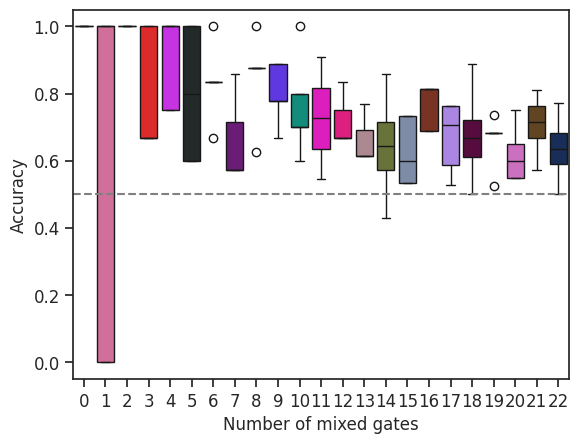

In [15]:
avg_per_exp = results_df.groupby(["Num gates", "Fold"]).mean(numeric_only=True).reset_index()
sns.boxplot(data = avg_per_exp, x="Num gates", y="Correctly predicted", palette=cmap_24)
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.xlabel("Number of mixed gates")
plt.ylabel("Accuracy")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_avg_per_num_gates_and_fold_correctly_predicted_box.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3440671/661257457.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_per_num_gates, x="Num gates", y="Correctly predicted", palette=cmap_24)
/tmp/ipykernel_3440671/661257457.py:2: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  sns.barplot(data=avg_per_num_gates, x="Num gates", y="Correctly predicted", palette=cmap_24)


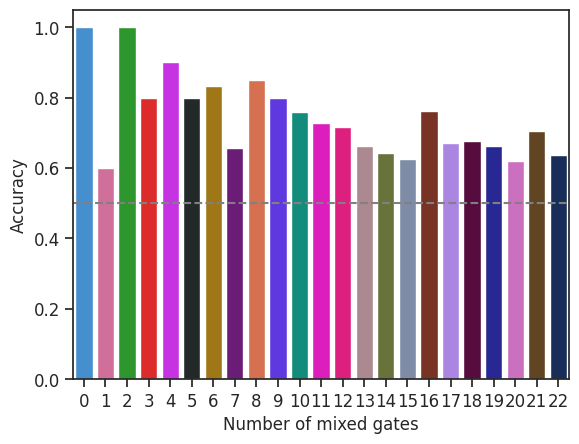

In [16]:
avg_per_num_gates = results_df.groupby("Num gates").mean(numeric_only=True).reset_index()
sns.barplot(data=avg_per_num_gates, x="Num gates", y="Correctly predicted", palette=cmap_24)
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.xlabel("Number of mixed gates")
plt.ylabel("Accuracy")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_avg_per_num_gates_correctly_predicted_bar.pdf", bbox_inches="tight")
plt.show()

In [17]:
avg_per_node_and_num_gates = results_df.groupby(["Num gates", "Gate"]).mean(numeric_only=True).reset_index()

/tmp/ipykernel_3440671/690644873.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=avg_per_node_and_num_gates, x="Num gates", y="Correctly predicted", palette=cmap_24)
/tmp/ipykernel_3440671/690644873.py:1: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  sns.boxplot(data=avg_per_node_and_num_gates, x="Num gates", y="Correctly predicted", palette=cmap_24)


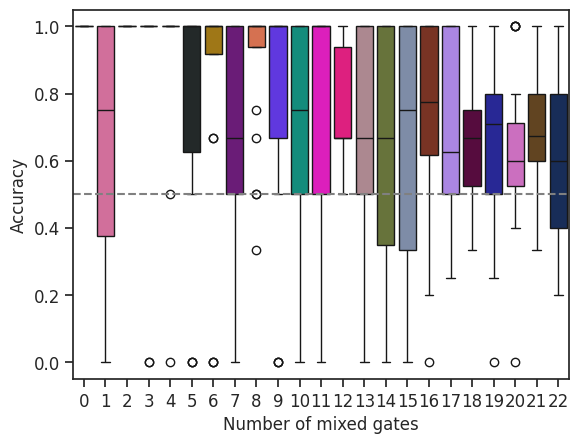

In [18]:
sns.boxplot(data=avg_per_node_and_num_gates, x="Num gates", y="Correctly predicted", palette=cmap_24)
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.xlabel("Number of mixed gates")
plt.ylabel("Accuracy")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_avg_per_node_and_num_gates_correctly_predicted_box.pdf", bbox_inches="tight")
plt.show()

In [19]:
results_df[results_df['Num gates']==1]

,Num gates,Fold,Gate,True type,Predicted type,Gate AND param,Correctly predicted
1,1,0,_and_6,logic_gate_OR,logic_gate_OR,0.005879,True
255,1,1,_and_1,logic_gate_OR,logic_gate_OR,0.006323,True
509,1,2,_and_7,logic_gate_OR,logic_gate_AND,0.994125,False
763,1,3,_and_10,logic_gate_AND,Unknown,0.530290,False
1017,1,4,_and_7,logic_gate_OR,logic_gate_OR,0.005877,True


In [26]:
avg_per_num_gates

,Num gates,Fold,Gate AND param,Correctly predicted
0,0,2.0,NaN,1.000000
1,1,2.0,0.308499,0.600000
2,2,2.0,0.401231,1.000000
3,3,2.0,0.598750,0.800000
4,4,2.0,0.549432,0.900000
5,5,2.0,0.440721,0.800000
6,6,2.0,0.467049,0.833333
7,7,2.0,0.401197,0.657143
8,8,2.0,0.178846,0.850000
9,9,2.0,0.445095,0.800000


/tmp/ipykernel_3440671/3950647875.py:2: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  sns.barplot(data=avg_per_node_and_num_gates, x="Gate", y="Correctly predicted", hue="Num gates", palette=cmap_24)


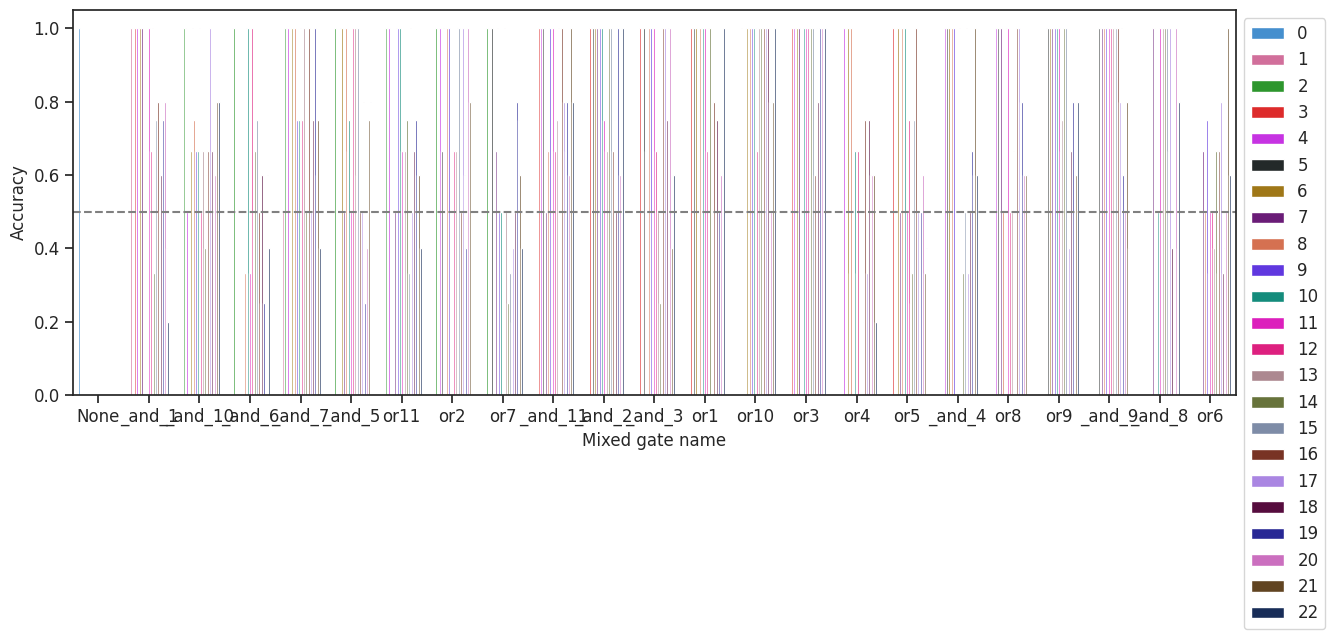

In [27]:
plt.figure(figsize=(15,5))
sns.barplot(data=avg_per_node_and_num_gates, x="Gate", y="Correctly predicted", hue="Num gates", palette=cmap_24)
plt.legend(bbox_to_anchor=(1,1))
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.xlabel("Mixed gate name")
plt.ylabel("Accuracy")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_avg_per_node_and_num_gates_correctly_predicted_single_bars.pdf", bbox_inches="tight")
plt.show()

In [28]:
results_df["Accuracy"] = results_df["Correctly predicted"].astype(int)

/tmp/ipykernel_3440671/984964430.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=results_df, x="Num gates", y="Accuracy", linestyles="none", errorbar=("ci", 95), palette=cmap_24)
/tmp/ipykernel_3440671/984964430.py:1: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  sns.pointplot(data=results_df, x="Num gates", y="Accuracy", linestyles="none", errorbar=("ci", 95), palette=cmap_24)


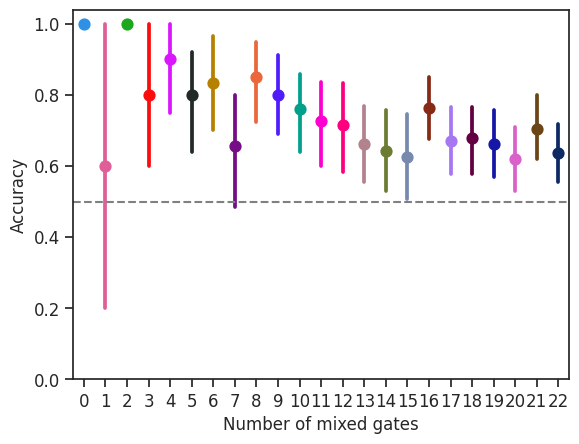

In [29]:
sns.pointplot(data=results_df, x="Num gates", y="Accuracy", linestyles="none", errorbar=("ci", 95), palette=cmap_24)
plt.ylim((0,None))
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.xlabel("Number of mixed gates")
plt.ylabel("Accuracy")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_avg_acc_per_num_gates_with_ci_pointplot.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3440671/1748125744.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = results_df, x="Num gates", y="Accuracy", palette=cmap_24)
/tmp/ipykernel_3440671/1748125744.py:1: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  sns.boxplot(data = results_df, x="Num gates", y="Accuracy", palette=cmap_24)


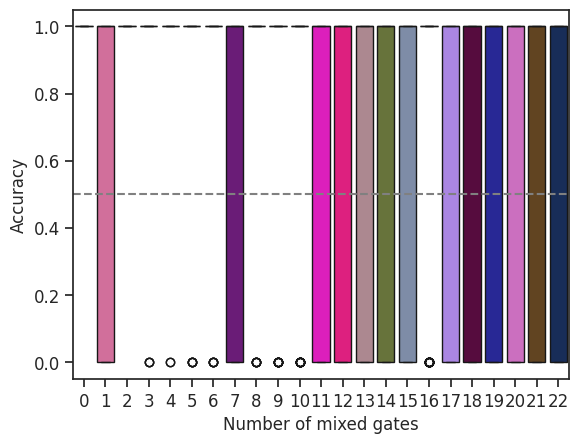

In [30]:
sns.boxplot(data = results_df, x="Num gates", y="Accuracy", palette=cmap_24)
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.xlabel("Number of mixed gates")
plt.ylabel("Accuracy")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_correctly_predicted_box.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3440671/1867831784.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = results_df, x="Num gates", y="Accuracy", palette=cmap_24)
/tmp/ipykernel_3440671/1867831784.py:1: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  sns.barplot(data = results_df, x="Num gates", y="Accuracy", palette=cmap_24)


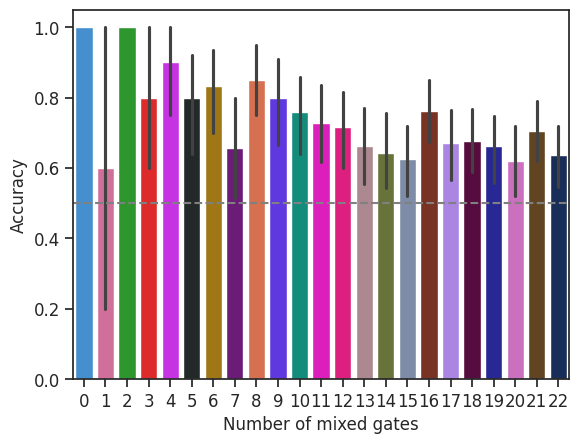

In [31]:
sns.barplot(data = results_df, x="Num gates", y="Accuracy", palette=cmap_24)
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.xlabel("Number of mixed gates")
plt.ylabel("Accuracy")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_correctly_predicted_bar.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3440671/596504390.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plt_data, x="True type", y="Accuracy", palette={"logic_gate_OR": "#0072B2",  "logic_gate_AND": "#D55E00"})


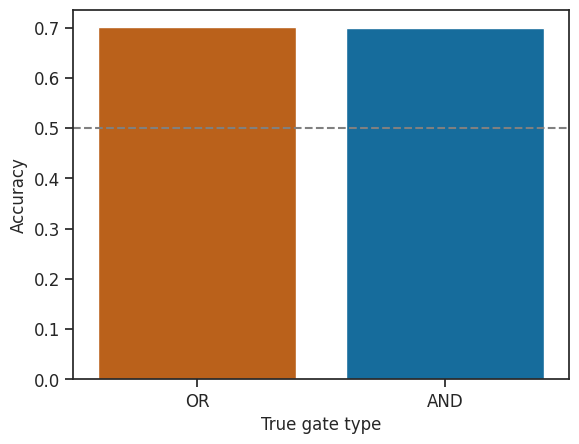

In [32]:
plt_data = results_df.groupby(["True type"]).mean(numeric_only=True).reset_index(drop=False)
sns.barplot(data=plt_data, x="True type", y="Accuracy", palette={"logic_gate_OR": "#0072B2",  "logic_gate_AND": "#D55E00"})
t = plt.xlabel("True gate type")
t = plt.xticks([0,1], labels=["OR", "AND"])
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Gates_accuracy_per_run_AND_vs_OR.pdf", bbox_inches="tight")
plt.show()

In [33]:
results_df[["True type", "Predicted type"]]
results_df["True"] = [int(gate=="logic_gate_AND") for gate in results_df["True type"]]
results_df["Pred"] = [int(gate=="logic_gate_AND") for gate in results_df["Predicted type"]]
results_df

,Num gates,Fold,Gate,True type,Predicted type,Gate AND param,Correctly predicted,Accuracy,True,Pred
0,0,0,None,NaN,NaN,NaN,True,1,0,0
1,1,0,_and_6,logic_gate_OR,logic_gate_OR,0.005879,True,1,0,0
2,2,0,_and_5,logic_gate_AND,logic_gate_AND,0.994124,True,1,1,1
3,2,0,_and_6,logic_gate_AND,logic_gate_AND,0.994127,True,1,1,1
4,3,0,_and_5,logic_gate_OR,logic_gate_AND,0.994120,False,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1265,22,4,or7,logic_gate_AND,logic_gate_AND,0.994105,True,1,1,1
1266,22,4,or8,logic_gate_AND,logic_gate_AND,0.994026,True,1,1,1
1267,22,4,or9,logic_gate_OR,logic_gate_AND,0.993876,False,0,0,1
1268,22,4,or10,logic_gate_AND,logic_gate_AND,0.994216,True,1,1,1


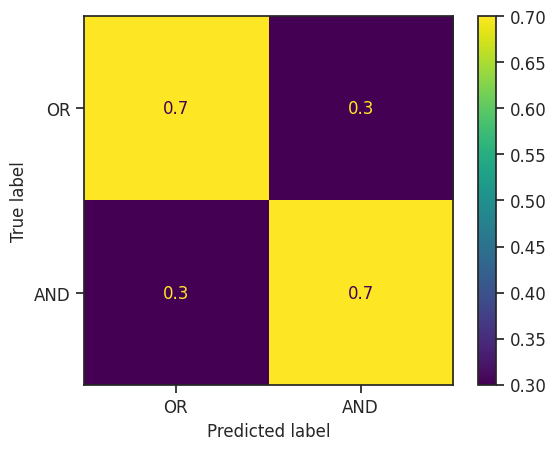

In [34]:
ConfusionMatrixDisplay.from_predictions(results_df.loc[1:, "True"], results_df.loc[1:, "Pred"], 
                                        display_labels=["OR", "AND"], normalize="true")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Gates_confusion_matrix_AND_vs_OR.pdf", bbox_inches="tight")
plt.show()

In [35]:
G = DREAMBioFuzzNet.build_BioFuzzNet_from_file(pkn)

In [36]:
lengths = []
for n in G.fuzzy_nodes:
    current_path_length = 1000
    for r in G.root_nodes:
        try:
            new_shortest_path = nx.shortest_path_length(G, source=r, target=n)
        except nx.exception.NetworkXNoPath:
            new_shortest_path = 1000
        if new_shortest_path<current_path_length:
            current_path_length = new_shortest_path
    lengths.append(current_path_length)
lengths
sorted_nodes = [n for l, n in sorted(zip(lengths, G.fuzzy_nodes))]
depths = [l for l, n in sorted(zip(lengths, G.fuzzy_nodes))]

In [57]:
avg_per_node

,Gate,Num gates,Fold,Gate AND param,Correctly predicted,Accuracy,True,Pred
0,None,0.000000,2.000000,NaN,1.000000,1.000000,0.000000,0.000000
1,_and_1,15.571429,1.839286,0.535260,0.642857,0.642857,0.571429,0.535714
2,_and_10,13.925373,1.955224,0.529955,0.686567,0.686567,0.447761,0.522388
3,_and_11,15.017241,2.051724,0.551111,0.793103,0.793103,0.517241,0.551724
4,_and_2,14.877193,2.087719,0.543322,0.842105,0.842105,0.491228,0.543860
5,_and_3,15.112903,2.032258,0.515915,0.758065,0.758065,0.532258,0.516129
6,_and_4,15.509804,1.823529,0.451571,0.666667,0.666667,0.470588,0.450980
7,_and_5,14.465517,1.965517,0.465922,0.637931,0.637931,0.448276,0.465517
8,_and_6,14.770492,1.934426,0.459500,0.508197,0.508197,0.393443,0.459016
9,_and_7,14.031250,2.234375,0.469113,0.734375,0.734375,0.453125,0.468750


/tmp/ipykernel_3440671/2933660248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["depth"] = [lengths[i] for i, n in enumerate(G.fuzzy_nodes) for node in temp["Gate"] if n==node ]


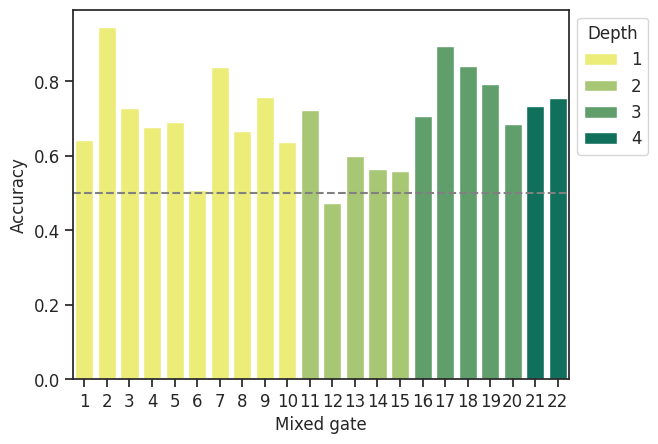

In [82]:
avg_per_node = results_df.groupby("Gate").mean(numeric_only=True).reset_index()
temp = avg_per_node[avg_per_node["Gate"]!="None"]
temp["depth"] = [lengths[i] for i, n in enumerate(G.fuzzy_nodes) for node in temp["Gate"] if n==node ]

sns.barplot(data=temp.sort_values("depth"), x="Gate", y="Correctly predicted",
            palette="summer_r", hue="depth")
t = plt.xticks(rotation=90)
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.xlabel("Mixed gate")
plt.xticks(ticks=[i for i in range(len(sorted_nodes))], labels=[i+1 for i in range(len(sorted_nodes))], rotation=0)
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1,1), title="Depth")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_avg_per_node_correctly_predicted_bar.pdf", bbox_inches="tight")
plt.show()

In [67]:
temp.dtypes

Gate                    object
Num gates              float64
Fold                   float64
Gate AND param         float64
Correctly predicted    float64
Accuracy               float64
True                   float64
Pred                   float64
depth                    int64
dtype: object

In [68]:
lengths

[1, 3, 3, 3, 1, 1, 1, 1, 4, 3, 1, 2, 3, 1, 1, 1, 2, 2, 2, 2, 1, 4]

In [38]:
avg_per_node

,Gate,Num gates,Fold,Gate AND param,Correctly predicted,Accuracy,True,Pred
0,None,0.000000,2.000000,NaN,1.000000,1.000000,0.000000,0.000000
1,_and_1,15.571429,1.839286,0.535260,0.642857,0.642857,0.571429,0.535714
2,_and_10,13.925373,1.955224,0.529955,0.686567,0.686567,0.447761,0.522388
3,_and_11,15.017241,2.051724,0.551111,0.793103,0.793103,0.517241,0.551724
4,_and_2,14.877193,2.087719,0.543322,0.842105,0.842105,0.491228,0.543860
5,_and_3,15.112903,2.032258,0.515915,0.758065,0.758065,0.532258,0.516129
6,_and_4,15.509804,1.823529,0.451571,0.666667,0.666667,0.470588,0.450980
7,_and_5,14.465517,1.965517,0.465922,0.637931,0.637931,0.448276,0.465517
8,_and_6,14.770492,1.934426,0.459500,0.508197,0.508197,0.393443,0.459016
9,_and_7,14.031250,2.234375,0.469113,0.734375,0.734375,0.453125,0.468750


/tmp/ipykernel_3440671/134241734.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=avg_per_node_and_num_gates, x="Gate", y="Correctly predicted",
/tmp/ipykernel_3440671/134241734.py:1: UserWarning: The palette list has more values (24) than needed (22), which may not be intended.
  sns.boxplot(data=avg_per_node_and_num_gates, x="Gate", y="Correctly predicted",


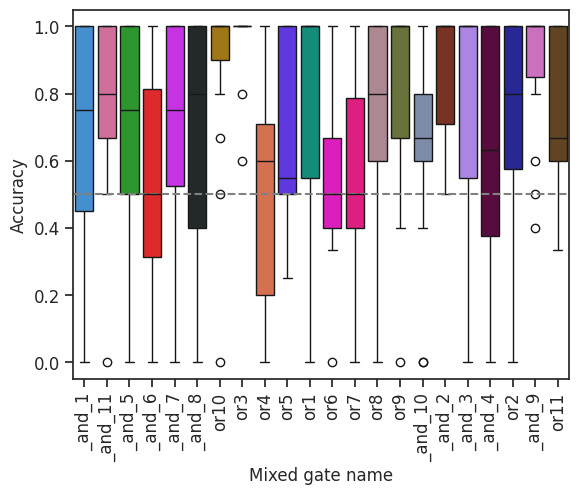

In [39]:
sns.boxplot(data=avg_per_node_and_num_gates, x="Gate", y="Correctly predicted", 
            palette=cmap_24, order=sorted_nodes)
t = plt.xticks(rotation=90)
plt.axhline(y=0.5, linestyle="--", color="grey")
plt.xlabel("Mixed gate name")
plt.ylabel("Accuracy")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_avg_per_node_and_num_gates_correctly_predicted_box.pdf", bbox_inches="tight")
plt.show()

In [40]:
MSEs = (RMSEs.set_index(["Fold", "Num gates"])**2).reset_index()
MSEs = MSEs.melt(id_vars=["Num gates", "Fold"], value_name="MSE", var_name="Node")
MSEs = MSEs.groupby(["Fold", "Num gates"]).mean(numeric_only=True).reset_index()

/tmp/ipykernel_3440671/2486017580.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = MSEs, x="Num gates", y="MSE", palette=cmap_24)
/tmp/ipykernel_3440671/2486017580.py:1: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  sns.boxplot(data = MSEs, x="Num gates", y="MSE", palette=cmap_24)


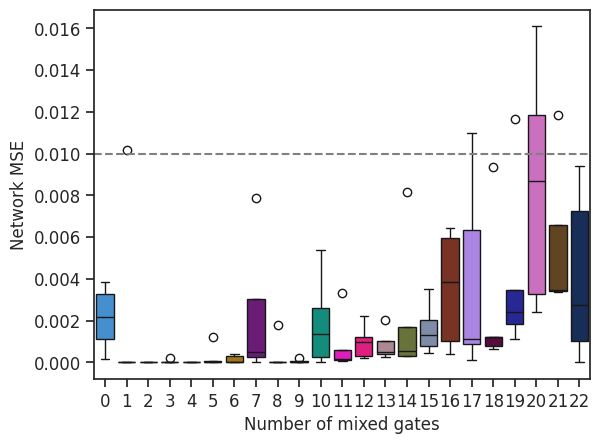

In [41]:
sns.boxplot(data = MSEs, x="Num gates", y="MSE", palette=cmap_24)
plt.xlabel("Number of mixed gates")
plt.ylabel("Network MSE")
plt.axhline(y=0.01, linestyle="--", color="grey")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Gates_avg_per_num_gates_and_fold_network_MSE_box.pdf", bbox_inches="tight")
plt.show()